# Demonstration
## Preparations
To make this demo more readable, we import everything we use in the following here:

In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob

import pandas as pd

# Own framework
from framework.network import NeuralNetwork
from framework.layers import FullyConnectedLayer
from framework.activation_layers import Sigmoid, Softmax, ReLU
from framework.input_layer import DefaultInputLayer
from framework.optimizer import SGD
from framework.utils import classes_to_one_hot_vector, get_classification_report, get_confusion_matrix
from framework.hyperparameter_search import HyperparameterSearch

## Load Data
For this demonstration, we added some of our own training data and the validation data that is available on WueCampus. The following just trains on the raw training data without any preprocessing. Thus, it is not as good as our real model, but our goal here is to keep it simple and not to achieve a good performance.

In [2]:
class_names = ["idle", "swipe_left", "swipe_right", "rotate"]

In [3]:
# Load training data
# By using glob and pandas, we can import the data from multiple csv-files very easily
all_files = glob(os.path.join("example_data/train", "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
df_train = pd.concat(df_from_each_file, ignore_index=True)
x_train = df_train.iloc[:, 1:-1].to_numpy()

# Load validation data the same way as the training data
all_files = glob(os.path.join("example_data/validation", "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
df_val = pd.concat(df_from_each_file, ignore_index=True)
x_val = df_val.iloc[:, 1:-1].to_numpy()

For the true labels we can use a convenient function from our framework that converts a list of class labels to one hot vectors 

In [4]:
y_train = classes_to_one_hot_vector(df_train["ground_truth"].to_numpy(), class_names)
y_val = classes_to_one_hot_vector(df_val["ground_truth"].to_numpy(), class_names)

## Fully Connected Neural Network
The following defines a Neural Network model. Our framework creates a neural network from an input layer that handles the conversion from a numpy input to the internal `Tensor`-class and a list of layers for the architecture. The inputs are then passed through the layers in the same order as defined in the list.

In [5]:
# Define Model Architecture
layers = [
    FullyConnectedLayer(48, 64),
    ReLU(),
    FullyConnectedLayer(64, 32),
    Sigmoid(),
    FullyConnectedLayer(32, 4),
    Softmax(),
]
nn = NeuralNetwork(DefaultInputLayer(), layers)

To train the model, the `SGD`-class is used. With the static function update, the given model can be trained using stochastic gradient descent. 

In [6]:
# Train the Model
SGD.update(
    nn=nn,
    loss="CrossEntropy",
    lr=0.01,
    epochs=50,
    data=(x_train, y_train),
)

training:   0%|          | 0/50 [00:00<?, ?it/s]

(0.9263746505125815, 0.18829029563416969)

# Hyperparameter Search
Our framework also implements a way to do a hyperparameter search for a given set of parameters. You can for example try out different numbers of neurons, different activation layers and more. You can also use different scores for evaluation. The default is the F1-score. It returns the best model that was found and a pandas dataframe listing all trials and the corresponding scores.

In [7]:
from framework.utils import get_accuracy

Searcher = HyperparameterSearch(
    training_data=(x_train, y_train),
    validation_data=(x_val, y_val),
    performance_scores=[("Accuracy", get_accuracy), "F1", "Precision"]
)

df = Searcher(
    learning_rates=[0.01],
    n_epochs=[50],
    n_layers=[3],
    n_neurons=[32, 64],
    activations=["relu", "sigmoid"]
)

  0%|          | 0/16 [00:00<?, ?it/s]

In [8]:
df

At last, we also have some convenient ways to visualize the performance of our model:

In [9]:
preds = nn(x_val)
get_classification_report(preds, y_val, sparse=False, class_names=class_names)

Prediction:   0%|          | 0/1962 [00:00<?, ?it/s]

Precision    Recall  F1-Score  Fraction
classes idle                   0.880212  0.891421  0.885781  0.760061
        swipe_left             1.000000  0.000000  0.000000  0.064697
        swipe_right            0.818182  0.194245  0.313953  0.070810
        rotate                 0.329356  0.673171  0.442308  0.104432
global  Micro Avg / Accuracy   0.761589  0.761589  0.761589  1.000000
        Macro Avg              0.756937  0.439709  0.410511  1.000000
        Weighted Avg           0.826042  0.761589  0.741670  1.000000

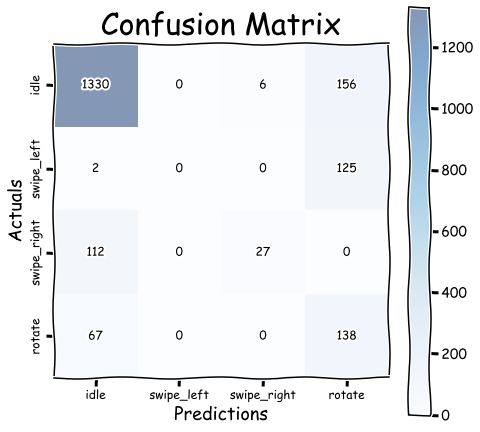

Predicted,idle,swipe_left,swipe_right,rotate
True Labels,,,,
idle,1330,0,6,156
swipe_left,2,0,0,125
swipe_right,112,0,27,0
rotate,67,0,0,138


In [10]:
get_confusion_matrix(preds, y_val, sparse=False, class_names=class_names)